<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

# RNA in PyRosetta
Keywords: classify_base_pairs, RNA torsions, RNA score terms, RNA motifs, mutate_position, RNA thread, RNA minimize, RNA_HelixAssembler, RNA fragment assembly, FARFAR protocol, rna_denovo

## References

1. R. Das et al., "Atomic accuracy in predicting and designing noncanonical RNA structure," Nature Methods 7:4, 291-294 (2010).


2. A. Watkins et al., "Blind prediction of noncanonical RNA structure at atomic accuracy," Science Advances 4:5 (2018).


## Introduction

In this lab, we will explore common tasks and approaches for working with RNA using Rosetta. We will be focusing on a simple system that includes a helix capped by a tetraloop for this exercise.

In [1]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

In [2]:
from pyrosetta import *
init()

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python37.mac 2019.35+release.767c1ea25c572fbc078db45ad65dddb507240ad3 2019-08-22T09:19:33] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python37.mac r231 2019.35+release.767c1ea25c5 767c1ea25c572fbc078db45ad65dddb507240ad3 http://www.pyrosetta.org 2019-08-22T09:19:33
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/ramyar/Dropbox/GradSchool/Research/packages/PyRosetta4.Release.python37.mac.release-231/setup/build/lib/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=653634719 seed_offset=0 real_seed=653634719
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=653634719 RG_type=mt19937


In [3]:
from pyrosetta.rosetta import *
from pyrosetta.rosetta.core.pose.rna import *
from pyrosetta.rosetta.core.pose import *

## Exploring geometry for RNA ##

Let's load in this structure with PyRosetta (make sure that you have the PDB file located in your current directory):

`cd google_drive/My\ Drive/student-notebooks/
pose = pose_from_pdb("inputs/stem_loop.pdb")`

In [4]:
### BEGIN SOLUTION
pose = pose_from_pdb("inputs/stem_loop.pdb")
### END SOLUTION

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 980 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.05936 seconds.
core.import_pose.import_pose: File 'inputs/stem_loop.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.chirality_resolution: Flipping atom xyz for H5' and H5'' for residue   C


Let's explore the structure in this PDB file. First, use `pose.sequence()` to look at the sequence:

In [5]:
# print out the sequence of the pose
### BEGIN SOLUTION
pose.sequence()
### END SOLUTION

'cauccgaaaggaug'

We can see that the pose seems to contain RNA residues. To check this, let's go through the pose residue by residue, checking if each one is RNA.

In [6]:
for ii in range(pose.size()):
    print(pose.residue_type(5).is_RNA())

True
True
True
True
True
True
True
True
True
True
True
True
True
True


RNA bases interact with each other via **base pairing**, either through the Watson-Crick base pairs that make up standard A-form helices or through non-canonical base pairing interactions. We can use the `classify_base_pairs` function (this lives in `core:pose:rna` which was loaded above) to find and classify all the base pairs in the current pose. Let's take a look.

In [7]:
base_pairs = classify_base_pairs(pose)
for base_pair in base_pairs:
    print(base_pair)

basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv
1 14 WC WC ANTI
2 13 WC WC ANTI
3 12 WC WC ANTI
4 11 WC WC ANTI
5 10 WC WC ANTI
6 9 SUGAR HOOG ANTI


We can see that the RNA molecule consists of Watson-Crick base pairs between residues 1-5 and residues 10-14 forming a standard RNA helix. We can also see that residues 6 and 9 form a non-canonical base pair interaction between the sugar and Hoogsteen edges of the respective bases. We can think of this structure as a simple stem-loop, with an idealized A-form helix between residues 1-5 and residues 10-14, and with a tetraloop connecting these chains.

Let's use some of Rosetta's tools for measuring **distances and torsions** to understand the typical geometry of an idealized A-form helix.

What is the distance between the phosphate atoms of two consecutive residues in one strand of a helix? Check this for a couple pairs of residues.

In [8]:
P1_xyz = pose.residue(1).xyz("P")
P2_xyz = pose.residue(2).xyz("P")
P3_xyz = pose.residue(3).xyz("P")
print((P1_xyz - P2_xyz).norm())
print((P2_xyz - P3_xyz).norm())

5.923353746008057
5.846964169549871


RNA nucleotides are quite large compared to amino acids, with many more torsion angles. In the diagram of a nucleotide below, we can see the backbone torsions applicable to RNA: $\alpha$, $\beta$, $\gamma$, $\delta$, $\epsilon$, $\zeta$, and $\chi$.

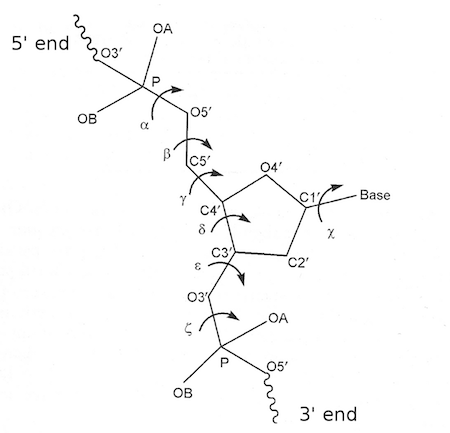

In [4]:
from IPython.display import Image
Image('./Media/nucleotide_torsions.png',width='500')

We can access the values of these torsions through the pose object. Just like protein torsions can be accessed with functions like `pose.phi(resid)`, RNA torsions can be accessed with analogous functions like `pose.alpha(resid)`.

**Exercise**: Below, make a function that prints out all the torsions for a given residue. Then, using that function, check the torsions for three different residues in the RNA helix. How similar are torsion angles for different residues in an idealized helix?

In [9]:
### BEGIN SOLUTION
def print_torsions(pose, resi):
    print("%s: %f" % ("alpha", pose.alpha(resi)))
    print("%s: %f" % ("beta", pose.beta(resi)))
    print("%s: %f" % ("gamma", pose.gamma(resi)))
    print("%s: %f" % ("delta", pose.delta(resi)))
    print("%s: %f" % ("epsilon", pose.epsilon(resi)))
    print("%s: %f" % ("zeta", pose.zeta(resi)))
    print("%s: %f" % ("chi", pose.chi(resi)))
### END SOLUTION

In [10]:
### BEGIN SOLUTION
print("Torsions for residue 2:")
print_torsions(pose, 2)
print("Torsions for residue 3:")
print_torsions(pose, 3)
print("Torsions for residue 12:")
print_torsions(pose, 12)
### END SOLUTION

Torsions for residue 2:
alpha: -72.516450
beta: 178.544461
gamma: 58.327244
delta: 79.813633
epsilon: -152.375244
zeta: -70.561778
chi: 74.780524
Torsions for residue 3:
alpha: -65.899308
beta: 173.462004
gamma: 56.858161
delta: 79.609718
epsilon: -152.592269
zeta: -70.540365
chi: 77.981938
Torsions for residue 12:
alpha: -67.502850
beta: 174.408225
gamma: 56.171977
delta: 81.812182
epsilon: -149.905716
zeta: -76.028946
chi: 75.291052


## Scoring RNA poses ##

Rosetta's energy functions provide a mechanism to score RNA structures, rewarding realistic conformations using a variety of score terms. In this section, we will see how to score RNA poses, and we will use these score terms to better understand our structure.

To score structures with RNA in Rosetta, it is best to use a high-resolution energy function designed to work with RNA, for instance `stepwise/rna/rna_res_level_energy4.wts`. In fact, the standard high resolution energy function used in Rosetta does not include the score terms that are quite helpful for modeling RNA. To see this, we will evaluate our RNA pose with the `ref2015` score function and `stepwise/rna/rna_res_level_energy4.wts`, comparing the resulting score term values.

In [11]:
hires_sf = core.scoring.ScoreFunctionFactory.create_score_function("ref2015");

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/rama/fd/all.ramaProb
basic.io.database: Database file opened: scoring/score_functions/rama/fd/prepro.ramaProb
basic.io.database: Database file opened: scoring/score_functions/omega/omega_ppdep.all.txt
basic.io.database: Database file opened: scoring/score_functions/omega/omega_ppdep.gly.txt
basic.io.database: Database file opened: scoring/score_functions/omega/omega_ppdep.pro.txt
basic.io.database: Database file opened: scoring/score_functions/omega/omega_ppdep.valile.txt
basic.io.database: Database file opened: scoring/score_functions/P_AA_pp/P_AA
basic.io.database: Dat

In [12]:
hires_sf.show(pose)

core.scoring.ScoreFunction: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       1.000    -146.195    -146.195
 fa_rep                       0.550      21.661      11.914
 fa_sol                       1.000     181.903     181.903
 fa_intra_rep                 0.005     104.969       0.525
 fa_intra_sol_xover4          1.000      43.757      43.757
 lk_ball_wtd                  1.000     -23.168     -23.168
 fa_elec                      1.000     -11.254     -11.254
 pro_close                    1.250       0.000       0.000
 hbond_sr_bb                  1.000       0.000       0.000
 hbond_lr_bb                  1.000       0.000       0.000
 hbond_bb_sc                  1.000       0.000       0.000
 hbond_sc                     1.000     -23.799     -23.799
 dslf_fa13                    1.250       0.000       0.000
 omega  

Note that `ref2015` does contain some terms that are used for RNA modeling like VDW and hydrogen bonding score terms. What extra terms are included in the RNA high resolution score function?

In [5]:
rna_hires_sf = core.scoring.ScoreFunctionFactory.create_score_function("stepwise/rna/rna_res_level_energy4.wts");

core.scoring.etable: Starting energy table calculation
core.scoring.etable: smooth_etable: changing atr/rep split to bottom of energy well
core.scoring.etable: smooth_etable: spline smoothing lj etables (maxdis = 6)
core.scoring.etable: smooth_etable: spline smoothing solvation etables (max_dis = 6)
core.scoring.etable: Finished calculating energy tables.
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBPoly1D.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBFadeIntervals.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/HBEval.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/DonStrength.csv
basic.io.database: Database file opened: scoring/score_functions/hbonds/ref2015_params/AccStrength.csv


In [6]:
rna_hires_sf.show(pose)

core.scoring.ScoreFunction: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.210    -212.399     -44.604
 fa_rep                       0.200      57.744      11.549
 fa_intra_rep                 0.003     186.211       0.540
 lk_nonpolar                  0.250      -9.222      -2.305
 fa_elec_rna_phos_phos        1.700       0.378       0.643
 rna_torsion                  1.000       3.751       3.751
 suiteness_bonus              1.000       0.000       0.000
 rna_sugar_close              0.820       3.938       3.229
 fa_stack                     0.130    -234.442     -30.477
 stack_elec                   0.760      -0.903      -0.686
 geom_sol_fast                0.170      74.843      12.723
 hbond_sr_bb_sc               0.960       0.000       0.000
 hbond_lr_bb_sc               0.960       0.000       0.000
 hbond_s

We can see that some new score terms in the high resolution RNA potential, including `rna_torsion`, `suiteness_bonus`, `rna_sugar_close`, and `fa_stack`. We will explore a few of these terms below. To learn about these and other score terms that have been included to more realistically model RNA, check out the papers referenced at the beginning of this notebook.

Analogous to the protein low-resolution potential, an RNA low-resolution potential has been developed to more quickly score RNA structures represented in centroid mode. Lets take a look at the score terms involved.

In [14]:
rna_lowres_sf = core.scoring.ScoreFunctionFactory.create_score_function("rna/denovo/rna_lores_with_rnp_aug.wts");

basic.io.database: Database file opened: scoring/rna/rna_atom_vdw.txt
basic.io.database: Database file opened: scoring/rna/rnp_atom_vdw_min_distances_reformat_MIN.txt
core.scoring.ScoringManager: Reading in: /Users/ramyar/Dropbox/GradSchool/Research/packages/PyRosetta4.Release.python37.mac.release-231/setup/build/lib/pyrosetta/database/scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading basepair x - y potential file: scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Finished reading basepair x - y potential file: scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading non - base - base x - y potential file: scoring/rna/rna_base_backbone_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading RNA backbone backbone potential file: scoring/rna/rna_backbone_backbone.dat
core.scoring.rna.RNP_LowResPotential: Reading RNP basepair x - y potential file: scoring/rna/rnp_base_pair.txt
core.scoring.rna

In [16]:
rna_lowres_sf.show(pose)

core.scoring.ScoreFunction: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 rna_data_backbone            2.000       0.000       0.000
 rna_vdw                      2.000       0.221       0.442
 rnp_vdw                     50.000       0.000       0.000
 rna_base_backbone            2.000      -1.884      -3.769
 rna_backbone_backbone        2.000       0.000       0.000
 rna_repulsive                5.000       0.000       0.000
 rna_base_pair                2.000     -53.214    -106.429
 rna_base_axis                0.400     -32.234     -12.894
 rna_base_stagger             2.000     -28.072     -56.143
 rna_base_stack               2.000      -3.243      -6.486
 rna_base_stack_axis          0.400     -20.598      -8.239
 rnp_base_pair                2.000       0.000       0.000
 rnp_stack                    5.000       0.000       0.000
 rnp_pai

We can see that when modeling an RNA molecule using centroid positions for nucleotides, we need to separately include terms for base pairing (`rna_base_pair`), base-backbone interactions (`rna_base_backbone`), and so on. 

Returning to the high resolution RNA score function, let us see if we can decompose the energies further to understand which parts of the structure contribute positively and negatively to its energy. First, we can decompose the energies per residue like below.

In [17]:
rna_hires_sf(pose)
nonzero_scores = pose.energies().residue_total_energies(4).show_nonzero()
print(nonzero_scores)

 fa_atr: -16.0481 fa_rep: 4.95774 fa_intra_atr: -10.6601 fa_intra_rep: 10.4003 fa_intra_sol: 6.2042 fa_intra_atr_nonprotein: -10.6601 fa_intra_rep_nonprotein: 10.4003 fa_intra_sol_nonprotein: 6.2042 lk_nonpolar: -0.837546 fa_elec_rna_phos_phos: -0.0122409 rna_torsion: 0.105802 rna_torsion_sc: 0.054655 rna_sugar_close: 0.471854 fa_stack: -14.7643 stack_elec: 0.0989445 geom_sol_fast: 6.69203 geom_sol_fast_intra_RNA: 0.348984 hbond_sc: -2.22045 ref: 2.82 total_score: -2.10402


A lot of the RNA specific energy terms make more sense when we look at pairs of residues. The energy graph object allows you to explore pairwise energies. The function below uses the energy graph to print out all non-zero scores between residues for a particular score term.

In [18]:
def print_nonzero_pairwise_energies(pose, energy_term, sf):
    sf(pose)
    energy_graph = pose.energies().energy_graph()
    for ii in range(1, pose.size() + 1):
        for jj in range(ii + 1, pose.size() + 1):
            edge = energy_graph.find_energy_edge(ii, jj)
            if (edge != None):
                emap = edge.fill_energy_map()
                resid1 = str(ii) + " " + pose.residue(ii).name1()
                resid2 = str(jj) + " " + pose.residue(jj).name1()
                resid_pair = resid1 + " " + resid2
                score = emap[ energy_term ]
                if score != 0:
                    print("%s: %f" % (resid_pair, score))

Using the function above, we're going to look at the stacking energies in the high resolution potential.

In [19]:
print_nonzero_pairwise_energies(pose, core.scoring.ScoreType.fa_stack, rna_hires_sf)

1 c 2 a: -8.786457
1 c 13 u: -0.021402
1 c 14 g: -0.014325
2 a 3 u: -17.195315
2 a 12 a: -1.166573
2 a 13 u: -0.021531
2 a 14 g: -18.136998
3 u 4 c: -10.651433
3 u 11 g: -0.182032
3 u 12 a: -0.025817
3 u 13 u: -2.437063
4 c 5 c: -11.016306
4 c 6 g: -0.042999
4 c 10 g: -0.170933
4 c 11 g: -0.003559
4 c 12 a: -7.643363
5 c 6 g: -14.998700
5 c 9 a: -0.055888
5 c 10 g: -0.004817
5 c 11 g: -9.170599
6 g 8 a: -1.056694
6 g 9 a: -0.381851
6 g 10 g: -11.820445
7 a 8 a: -21.526270
8 a 9 a: -22.045880
9 a 10 g: -13.441684
10 g 11 g: -18.409410
11 g 12 a: -18.811699
12 a 13 u: -16.199935
13 u 14 g: -9.002159


We can see that the **stacking energies** are highest for consecutive residues. In the idealized helix, the best stacking energy bonuses are given to stacked purine residues.

Now lets take a look at the **torsion energies**. Which energies are the highest? Where are these torsions in the structure?

In [20]:
print_nonzero_pairwise_energies(pose, core.scoring.ScoreType.rna_torsion, rna_hires_sf)

1 c 2 a: 0.041018
2 a 3 u: 0.003446
3 u 4 c: 0.012547
4 c 5 c: 0.015482
5 c 6 g: 0.048322
6 g 7 a: 0.273854
7 a 8 a: 0.096358
8 a 9 a: 0.020082
9 a 10 g: 0.248952
10 g 11 g: 0.019879
11 g 12 a: 0.012364
12 a 13 u: 0.017076
13 u 14 g: 0.002773


RNA structures are often viewed as being composed of small building blocks called **RNA motifs**. These motifs can be as simple as stacks of base pairs, which we have seen above. Typical motifs also include stereotyped loops, junctions, and tertiary contacts present across many common RNA molecules. Let's take a look to see whether any of these common RNA motifs are present in our simple stem loop structure.

In [21]:
lowres_potential = core.scoring.rna.RNA_LowResolutionPotential( "scoring/rna/rna_base_pair_xy.dat" )
rna_scoring_info = core.scoring.rna.rna_scoring_info_from_pose(pose).rna_filtered_base_base_info()
rna_motifs = core.scoring.rna.get_rna_motifs( pose, lowres_potential, rna_scoring_info)
print(rna_motifs)

core.scoring.rna.RNA_LowResolutionPotential: Reading basepair x - y potential file: scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Finished reading basepair x - y potential file: scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading non - base - base x - y potential file: scoring/rna/rna_base_backbone_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading RNA backbone backbone potential file: scoring/rna/rna_backbone_backbone.dat
WC_STACKED_PAIR [1, 2, 13, 14]
WC_STACKED_PAIR [4, 5, 10, 11]
WC_STACKED_PAIR [11, 12, 3, 4]
WC_STACKED_PAIR [10, 11, 4, 5]
WC_STACKED_PAIR [3, 4, 11, 12]
WC_STACKED_PAIR [12, 13, 2, 3]
WC_STACKED_PAIR [2, 3, 12, 13]
WC_STACKED_PAIR [13, 14, 1, 2]
U_TURN [6, 7, 8]
GNRA_TETRALOOP [6, 7, 8, 9]



We can see that our RNA structure includes many stacked Watson-Crick base pair, making the idealized A-form helix. In addition, the loop connecting the strands of the helix in our structure is a stereotyped "GNRA" tetraloop, taking a loop conformation that is common across many RNA structures in the PDB.

## Manipulating RNA poses ##

Rosetta allows you to not just explore a given PDB structure, but to manipulate and design structures. In this section, we discuss some basic ways to manipulate RNA structures, and we observe the effects of these manipulations on the structure's energy. For each manipulation, we will make a new copy of the pose to make sure that our changes do not affect the original structure we loaded in.

One basic manipulation we can make to an RNA structure is to change torsion angles for individual residues. Let's try this out on a residue in the A-form helix, and observe the effect on the rna_torsion score. Did the change we made make the score better or worse?

In [22]:
new_pose = Pose()
new_pose.assign(pose)
rna_hires_sf(pose)
torsion_score_before = pose.energies().total_energies()[core.scoring.ScoreType.rna_torsion]
new_pose.set_beta(2, 110)
rna_hires_sf(new_pose)
torsion_score_after = new_pose.energies().total_energies()[core.scoring.ScoreType.rna_torsion]
print("%s: %f" % ("Torsion score before", torsion_score_before))
print("%s: %f" % ("Torsion score after", torsion_score_after))

Torsion score before: 3.750853
Torsion score after: 4.166565


If you want to replace residues in an RNA molecule with their idealized versions, you can use the RNA_IdealCoord class in Rosetta. Below is an example for using that method to first replace a single residue with its idealized version, and then to replace all residues with their idealized versions across the whole pose.

In [23]:
ideal_pose_one = Pose()
ideal_pose_one.assign(pose)
resid = 2
core.pose.rna.RNA_IdealCoord().apply(ideal_pose_one, resid, core.chemical.rna.PuckerState.ANY_PUCKER, False)

ideal_pose = Pose()
ideal_pose.assign(pose)
core.pose.rna.RNA_IdealCoord().apply(ideal_pose, False)

**Exercise**: Figure out if the total energy of the pose went up or down after replacing one or all of the residues with their idealized versions. What can explain the difference? What about the total torsion energy only - does that go up or down in the pose with idealized residues compared to the original pose?

In [24]:
### BEGIN SOLUTION
rna_hires_sf(pose)
rna_hires_sf(ideal_pose)
rna_hires_sf(ideal_pose_one)
print(pose.energies().total_energy())
print(ideal_pose.energies().total_energy())
print(ideal_pose_one.energies().total_energy())
### END SOLUTION

-18.045673691089746
22.63480325590245
-1.1025695607212


In [25]:
### BEGIN SOLUTION
print(pose.energies().total_energies()[core.scoring.ScoreType.rna_torsion])
print(ideal_pose.energies().total_energies()[core.scoring.ScoreType.rna_torsion])
### END SOLUTION

3.7508527554837183
2.334597688825869


Another common manipulation for an RNA structure is to mutate the nucleotides to different bases. This is a manipulation that is commonly used while modeling one RNA structure using coordinates from another homologous (but not identical) structure. Below we can see how to mutate one residue of our RNA structure to another one. We include the `update_full_model_info_from_pose` command to ensure that the pose's internal data is kept up-to-date after the mutation is made.

In [26]:
mutated_pose = Pose()
mutated_pose.assign(pose)
print(pose.sequence())
rosetta.core.pose.rna.mutate_position(mutated_pose, 1, 'a')
core.pose.full_model_info.update_full_model_info_from_pose(mutated_pose)
print(mutated_pose.sequence())

cauccgaaaggaug
aauccgaaaggaug


**Exercise**: Make a function that mimics the 'rna_thread' Rosetta application, which takes in a pose and a new sequence and replaces all pose residues with the new sequence's residues. Remember to check that the pose's sequence and the new sequence have the same length. 

The pose's current sequence is `cauccgaaaggaug`. Use the function you wrote to make a version that has sequence `cauccuucgggaug` and one that has sequence `aaaaagaaauuuuu`.

In [27]:
### BEGIN SOLUTION
def rna_thread(pose, new_seq):
    if len(pose.sequence()) != len(new_seq):
        print("Sequences have different length; cannot rethread")
        return pose
    for ii in range(1, pose.size()+1):
        rosetta.core.pose.rna.mutate_position(pose, ii, new_seq[ii-1])
        core.pose.full_model_info.update_full_model_info_from_pose(pose)
    return pose
### END SOLUTION

In [28]:
### BEGIN SOLUTION
uucg_pose = Pose()
uucg_pose.assign(pose)
uucg_pose = rna_thread(uucg_pose, 'cauccuucgggaug')
print(uucg_pose.sequence())

auhelix_pose = Pose()
auhelix_pose.assign(pose)
auhelix_pose = rna_thread(auhelix_pose, 'aaaaagaaauuuuu')
print(auhelix_pose.sequence())
### END SOLUTION

cauccuucgggaug
aaaaagaaauuuuu


**Exercise**: The RNA high resolution potential includes hydrogen bonding terms. CG base pairs have more hydrogen bonds than AU base pairs. Compare the original pose with the pose that has all AU base pairs. What happens to the hydrogen bonding energy in the high resolution potential? 

In [29]:
### BEGIN SOLUTION
rna_hires_sf(auhelix_pose)
rna_hires_sf(pose)
auhelix_hbond_sc = auhelix_pose.energies().total_energies()[core.scoring.ScoreType.hbond_sc]
pose_hbond_sc = pose.energies().total_energies()[core.scoring.ScoreType.hbond_sc]
print('%s: %f' % ("AU Helix", auhelix_hbond_sc))
print('%s: %f' % ("CG Helix", pose_hbond_sc))
### END SOLUTION

AU Helix: -18.166948
CG Helix: -23.799493


**Exercise**: The stacking energies of the GAAA and UUCG tetraloops differ from each other. Which tetraloop provides the most favorable stacking energies overall? Can you figure out which pairs of residues have different stacking energies when the structure has changed (hint: you can base your code here off of the function `print_nonzero_pairwise_energies` above)?

In [30]:
### BEGIN SOLUTION
rna_hires_sf(uucg_pose)
rna_hires_sf(pose)
uucg_fa_stack = uucg_pose.energies().total_energies()[core.scoring.ScoreType.fa_stack]
pose_fa_stack = pose.energies().total_energies()[core.scoring.ScoreType.fa_stack]
print('%s: %f' % ("UUCG Loop", uucg_fa_stack))
print('%s: %f' % ("GAAA Loop", pose_fa_stack))
### END SOLUTION

UUCG Loop: -214.060807
GAAA Loop: -234.442137


In [31]:
### BEGIN SOLUTION
# The code below goes through the original pose with the GNRA loop and the uucg_pose, 
# printing out pairs of residues and the fa_stack score term between these residues
# if this score differs between the two poses.
rna_hires_sf(uucg_pose)
rna_hires_sf(pose)
pose_energy_graph = pose.energies().energy_graph()
uucg_energy_graph = uucg_pose.energies().energy_graph()
for ii in range(1, pose.size() + 1):
    for jj in range(ii + 1, pose.size() + 1):
        pose_edge = pose_energy_graph.find_energy_edge(ii, jj)
        uucg_edge = uucg_energy_graph.find_energy_edge(ii, jj)
        if (pose_edge != None)  and (uucg_edge != None):
            pose_emap = pose_edge.fill_energy_map()
            uucg_emap = uucg_edge.fill_energy_map()
            resid1 = str(ii) + " " + pose.residue(ii).name1()
            resid1_uucg = str(ii) + " " + uucg_pose.residue(ii).name1()
            resid2 = str(jj) + " " + pose.residue(jj).name1() 
            resid2_uucg = str(jj) + " " + uucg_pose.residue(jj).name1()
            resid_pair = resid1 + ", " + resid2
            resid_pair_uucg = resid1_uucg + ", " + resid2_uucg
            pose_score = pose_emap[ core.scoring.ScoreType.fa_stack ]
            uucg_score = uucg_emap[ core.scoring.ScoreType.fa_stack ]
            if pose_score != uucg_score:
                print("%s: %f; %s: %f" % (resid_pair, pose_score, resid_pair_uucg, uucg_score))
### END SOLUTION

4 c, 6 g: -0.042999; 4 c, 6 u: -0.020146
5 c, 6 g: -14.998700; 5 c, 6 u: -14.424303
5 c, 9 a: -0.055888; 5 c, 9 g: -0.040952
6 g, 8 a: -1.056694; 6 u, 8 c: -0.798130
6 g, 9 a: -0.381851; 6 u, 9 g: -0.142689
6 g, 10 g: -11.820445; 6 u, 10 g: -5.138552
7 a, 8 a: -21.526270; 7 u, 8 c: -14.881668
8 a, 9 a: -22.045880; 8 c, 9 g: -16.479345
9 a, 10 g: -13.441684; 9 g, 10 g: -13.063297


## Elements of RNA Structure Prediction

Many of the same strategies are used when modeling RNA as when modeling proteins. Below, we shall explore some of these procedures specifically applied to RNA molecules to appreciate how they may come together to give a modern structure prediction method.

### Generating an ideal A-form Helix

On a not wholly unrelated tangent, let us first see how we can quickly generate poses of ideal A-form RNA. You can think of this procedure as analogous to the `pose_from_seq` function used to generate protein poses from primary sequences. Let's use it now to generate a single-strand RNA pose with A-form torsions and the same sequence as the hairpin we've been examining so far.

```python
assembler = core.import_pose.RNA_HelixAssembler()
assembled_pose = assembler.build_init_pose(pose.sequence(), '')
```



In [7]:
### BEGIN SOLUTION
assembler = core.import_pose.RNA_HelixAssembler()
assembled_pose = assembler.build_init_pose(pose.sequence(), '')
### END SOLUTION

Let's get a `PyMOLMover` up and running so we can examine our new pose.

In [8]:
pmm = PyMOLMover()
pmm.set_PyMOL_model_name('assembled_pose')
pmm.apply(assembled_pose)

You can also use `RNA_HelixAssmebler` to generate poses that comprise two strands that form an ideal A-form helical stack, like residues 1-5 and 10-14 in the hairpin from above.

In [9]:
pmm_helix = PyMOLMover()
pmm_helix.set_PyMOL_model_name('helix_pose')
helix_pose = assembler.build_init_pose('ggg','ccc')

Looking in PyMOL, you may be able to appreciate that, true to its name, the `RNA_HelixAssembler` has generated a pose that looks quite helical.

In [10]:
pmm_helix.apply(helix_pose)

**Exercise**: Examine the torsions in several of the residues of `assembled_pose` using the `print_torsions` function you wrote earlier. How do they compare to the torsions from the starting stem loop?

### RNA Fragments

Given a library of RNA torsions excised from a published structure, fragment assembly methods will choose an n-mer in the current structure and replace the backbone geometry with the geometry of a corresponding n-mer from the library. Those of you familiar with protein structure prediction methods will recognize this strategy of fragment assembly.

We will implement a rudimentary version of this protocol for RNA below.

For the present exercise, we will use the torsions file `inputs/1jj2.torsions`, which comes from the crystal structure of a large ribosomal subunit. This library will be used to initialize a `Mover` specifically designed to perform fragment assembly on RNA molecules, `RNA_FragmentMover`.
```python
fragset = core.import_pose.libraries.RNA_LibraryManager.get_instance().rna_fragment_library("inputs/1jj2.torsions")
atom_level_domain_map = core.pose.toolbox.AtomLevelDomainMap(assembled_pose)
frag_mover = protocols.rna.denovo.movers.RNA_FragmentMover(fragset, atom_level_domain_map, 1, 0)
```
Don't worry too much about the other options that `RNA_FragmentMover`  requires at this point, but remember to include them if using this mover outside of this notebook.

In [11]:
### BEGIN SOLUTION
fragset = core.import_pose.libraries.RNA_LibraryManager.get_instance().rna_fragment_library("./inputs/1jj2.torsions")
atom_level_domain_map = core.pose.toolbox.AtomLevelDomainMap(assembled_pose)
frag_mover = protocols.rna.denovo.movers.RNA_FragmentMover(fragset, atom_level_domain_map, 1, 0)
### END SOLUTION

protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Reading in vall_torsions file: inputs/1jj2.torsions
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Lines read from vall_torsions file: 2754


Let's practice applying this mover to a `Pose`. To actually make a fragment assembly move, you can call the `random_fragment_insertion` method which requires two arguments:

1. An input `Pose`
2. The size of the fragment to substitute.

There is also an `apply()` method that can be called in a similar manner, but it simply calls `random_fragment_insertion()`, so the recommendation is to decrease overhead by calling `random_fragment_insertion()` where possible.

Let's pratice calling this method below.
```python
practice_pose = Pose()
practice_pose.assign(assembled_pose)
frag_mover.random_fragment_insertion(practice_pose, 3)
pmm.apply(practice_pose)
```


In [12]:
### BEGIN SOLUTION
practice_pose = Pose()
practice_pose.assign(assembled_pose)
frag_mover.random_fragment_insertion(practice_pose, 3)
pmm.apply(practice_pose)
### END SOLUTION

protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence auc  and sec. struct XXX ... found 32 potential fragments


Now that we know how to set up a fragment assembly mover in PyRosetta, try the excise below to write a quick folding routine that uses a fragment assembly strategy to try and fold the hairpin sequence. 

**Exercise**: Fill in the function below such that `fragment_assembly`
* Accepts an input `Pose`, `RNA_FragmentMover`, fragment size to substitute (`frag_size`), and number of trials (`n_trials`).
* Uses by default the `rna_lowres_sf` energy function from earlier but allows the user to specify a different energy function, if desired
* Performs a fragment substitution and accepts the substitution subject to the Metropolis criterion (assume $kT = 1$)
* Returns the lowest-energy pose found.

\* See section 4.1 of these notebooks for a review on Monte Carlo algorithms, if desired. 

Then, apply it to our newly assembled pose using the following recipe:

1. Run `fragment_assembly` using 3 nucleotide fragments for 400 trials. 
2. Then, run `fragment_assembly` using 2 nucleotide fragments for 300 trials.
3. Finally, run `fragment_assembly` using 1 nucleotide fragments for 300 trials.

In [15]:
import math
import random

def fragment_assembly(start_pose, frag_mover, frag_size, n_trials, sf=rna_lowres_sf):
    curr_pose = Pose()
    curr_pose.assign(start_pose)
    trial_pose = Pose()
    trial_pose.assign(curr_pose)
    opt_pose = Pose()
    opt_pose.assign(curr_pose)
    currE = newE = optE = sf(curr_pose)
    ### BEGIN SOLUTION
    for _ in range(n_trials):
        frag_mover.random_fragment_insertion(trial_pose, frag_size)
        newE = sf(trial_pose)
        if random.random() < math.exp(currE-newE):
            curr_pose.assign(trial_pose)
            currE = newE
            if currE < optE:
                optE = currE
                opt_pose.assign(curr_pose)
    ### END SOLUTION
    return curr_pose

frag_pose = fragment_assembly(assembled_pose, frag_mover, 3, 400)
frag_pose = fragment_assembly(frag_pose, frag_mover, 2, 300)
frag_pose = fragment_assembly(frag_pose, frag_mover, 1, 300)

protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence gaa  and sec. struct XXX ... found 76 potential fragments
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence agg  and sec. struct XXX ... found 64 potential fragments
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence gga  and sec. struct XXX ... found 62 potential fragments
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence gau  and sec. struct XXX ... found 37 potential fragments
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence cga  and sec. struct XXX ... found 77 potential fragments
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence aag  and sec. struct XXX ... found 64 potential fragments
protocols.rna.denovo.fragments.FullAtomRNA_Fragments: Picked Fragment Library for sequence ccg  and sec. s

Examine the fragment assembled `Pose` in PyMOL. Do you recognize any of the motifs from before?
```python
frag_pmm = PyMOLMover()
frag_pmm.set_PyMOL_model_name('frag_pose')
frag_pmm.apply(frag_pose)
```


In [16]:
### BEGIN SOLUTION
frag_pmm = PyMOLMover()
frag_pmm.set_PyMOL_model_name('frag_pose')
frag_pmm.apply(frag_pose)
### END SOLUTION

### Minimizing Structures with RNA

In principle, the standard `MinMover` that has been introduced previously in the context of minimizing purely protein structures can also be used to minimize poses with RNA (as long as the assigned energy function has score terms relevant to RNA and an appropriate `MoveMap` is provided).

However, as part of the `rna_denovo` protocol, Das and coworkers have developed a subroutine, `RNA_Minimize`, that is specifically geared toward handling minimization of poses with RNA, the use of which is detailed below.

We can access the `RNA_Minimize` mover from the `protocols` namespace. The relevant options object, `RNA_MinimizerOptions`, lives in the `import_pose.options` namespace. We will set the maximum number of iterations to 1000, using default values for other options.
```python
rna_min_options = core.import_pose.options.RNA_MinimizerOptions()
rna_min_options.set_max_iter(1000)
rna_minmizer = protocols.rna.denovo.movers.RNA_Minimizer(rna_min_options)
```

In [17]:
### BEGIN SOLUTION
rna_min_options = core.import_pose.options.RNA_MinimizerOptions()
rna_min_options.set_max_iter(1000)
rna_minimizer = protocols.rna.denovo.movers.RNA_Minimizer(rna_min_options)
### END SOLUTION

Unlike in the case of using `MinMover`, things like an appropriate energy function and `MoveMap` are generated by default by the `RNA_Minimizer` object. By default, `RNA_Minimizer` uses the same high-resolution energy function as above (`stepwise/rna/rna_res_level_energy4.wts`).

All that remains is to apply it to the relevant pose.
```python
rna_minimizer.apply(frag_pose)
```

In [18]:
### BEGIN SOLUTION
rna_minimizer.apply(frag_pose)
### END SOLUTION

protocols.rna.denovo.movers.RNA_Minimizer: Orienting 2' hydroxyls...
protocols.rna.denovo.movers.RNA_Minimizer: Minimizing...round= 1
protocols.rna.denovo.movers.RNA_Minimizer: Orienting 2' hydroxyls...
protocols.rna.denovo.movers.RNA_Minimizer: Minimizing...round= 2
protocols.rna.denovo.movers.RNA_Minimizer: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.210    -199.341     -41.862
 fa_rep                       0.200      33.513       6.703
 fa_intra_rep                 0.003     172.640       0.501
 lk_nonpolar                  0.250       1.420       0.355
 fa_elec_rna_phos_phos        1.700      -1.041      -1.769
 rna_torsion                  1.000       6.846       6.846
 suiteness_bonus              1.000       0.000       0.000
 rna_sugar_close              0.820       0.717       0.588
 fa_stack                

Let's see what changes minimization has wrought on our structure:
```python
min_pmm = PyMOLMover()
min_pmm.set_PyMOL_model_name('min_pose')
min_pmm.apply(frag_pose)
```

In [19]:
### BEGIN SOLUTION
min_pmm = PyMOLMover()
min_pmm.set_PyMOL_model_name('min_pose')
min_pmm.apply(frag_pose)
### END SOLUTION

**Exercise**: Using the functions described in the first part of the notebook, report on the following with respect to our de novo folded sequence:
1. Which base pairs, if any, were recovered?
2. Which motifs, if any, were recovered?


In [20]:
### BEGIN SOLUTION
base_pairs = classify_base_pairs(frag_pose)
for base_pair in base_pairs:
    print(base_pair)

lowres_potential = core.scoring.rna.RNA_LowResolutionPotential( "scoring/rna/rna_base_pair_xy.dat" )
rna_scoring_info = core.scoring.rna.rna_scoring_info_from_pose(frag_pose).rna_filtered_base_base_info()
rna_motifs = core.scoring.rna.get_rna_motifs( frag_pose, lowres_potential, rna_scoring_info)
print(rna_motifs)
### END SOLUTION

4 12 WC SUGAR ANTI
5 11 WC SUGAR ANTI
6 11 SUGAR WC ANTI
core.scoring.rna.RNA_LowResolutionPotential: Reading basepair x - y potential file: scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Finished reading basepair x - y potential file: scoring/rna/rna_base_pair_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading non - base - base x - y potential file: scoring/rna/rna_base_backbone_xy.dat
core.scoring.rna.RNA_LowResolutionPotential: Reading RNA backbone backbone potential file: scoring/rna/rna_backbone_backbone.dat



## Additional Exercises

### Post-mortem

Examine our final folded structure and the hairpin from the first part of the tutorial and think about the following questions:
* How well did our brief structure prediction algorithm do at recovering the hairpin we examined at the beginning? 
* Which parts were more successfully recovered? Which parts less so? Why might this be? 
* What would you do to improve on this method as it stands? Feel free to implement any ideas you have.

### FAR + FAR = FARFAR

Write a function analogous to the `fragment_assembly` function above that 
* Accepts an input `Pose`
* Performs a round of minimization using an `RNA_Minimizer`
* Returns the minimized structure

Using this new suboutine, craft your own `farfar` ( [Fragment Assembly of RNA with Full Atom Refinement](https://www.rosettacommons.org/docs/latest/application_documentation/rna/rna-denovo)) routine that performs multiple rounds of fragment assembly in a low-resolution potential followed by minimization in a high-resolution energy function. 

Try playing around with the various parameters and see how well you can recover the hairpin starting from just the sequence.


## RNA Structure Prediction Protocol

Below we will be running a short RNA de novo modeling run for the stem-loop sequence we have been working with thus far, making use of the **FARFAR protocol** (which you can run with the `rna_denovo` command in Rosetta). As discussed above, the FARFAR protocol involves a mixture of fragment assembly moves and full atom minimization moves. We will generate a small set of structures using FARFAR and compare the energy of the resulting structures to those constructed in the previous exercise. 

FARFAR builds models for a structure as specified in a FASTA file, making use of any structures of known sub-pieces (for instance, A-form helices for regions known to form stems). In this case, we will provide the helical portion of our structure between residues 1-5 and residues 10-14 as an input to the FARFAR protocol, so that the protocol only has to worry about sampling the loop. In a real modeling scenario, it is often the case that information about the secondary structure of the RNA is known, allowing us to make use of A-form helix rigid bodies to accelerate modeling.

Let's set up the fasta file and input PDB files to use as options for FARFAR; these files should be in the `inputs/` folder.

In [43]:
input_pdbs = rosetta.utility.vector1_std_string()
fasta_files = rosetta.utility.vector1_std_string()
input_pdbs.append("inputs/stem.pdb")
fasta_files = rosetta.utility.vector1_std_string()
fasta_files.append("inputs/stem_loop.fasta")

We will set up options for `rna_denovo` below, specifying the FASTA file, the input PDBs, the number of structures we would like to generate, and the output file (silent file format).

In [44]:
rna_de_novo_setup = core.import_pose.RNA_DeNovoSetup()
rna_de_novo_setup.set_fasta_files(fasta_files)
rna_de_novo_setup.set_minimize_rna(True)
rna_de_novo_setup.set_input_pdbs(input_pdbs)

In [45]:
rna_de_novo_setup.initialize_from_command_line()

core.import_pose.options.RNA_DeNovoProtocolOptions: Setting silent file name based on directory: notebooks.out
core.import_pose.import_pose: File 'inputs/stem.pdb' automatically determined to be of type PDB
core.import_pose.RNA_DeNovoSetup: Sequence:            cauccgaaaggaug
core.import_pose.RNA_DeNovoSetup: Secstruct:           ..............


In [46]:
rna_de_novo_options = rna_de_novo_setup.options()
rna_de_novo_options.set_nstruct(10)
rna_de_novo_options.set_silent_file("output/stem_loop.out")

Now we will run FARFAR by generating an `RNA_DeNovoProtocol` object and running it with `apply` on a starting pose. This will take a few minutes to run, and will generate 10 structures to the silent file specified above. As the protocol is running, take a look at the output to understand how it works. Note that for each structure generated, the protocol goes through various rounds of fragment assembly with fragments of size 3, 2, and 1, and then runs the RNA minimizer. This is similar to the protocol you made above!

In [47]:
rna_de_novo_protocol = rosetta.protocols.rna.denovo.RNA_DeNovoProtocol(rna_de_novo_options, rna_de_novo_setup.rna_params())

In [28]:
rna_de_novo_pose = rna_de_novo_setup.pose()
rna_de_novo_protocol.apply(rna_de_novo_pose)

protocols.rna.denovo.setup.RNA_DeNovoPoseInitializer: Setting desired secondary structure to: XXXXXXXXXXXXXX
core.conformation.Residue: [ WARNING ] Residue connection id changed when creating a new residue at seqpos 1
core.conformation.Residue: [ WARNING ] ResConnID info stored on the connected residue (residue 2) is now out of date!
core.conformation.Residue: [ WARNING ] Connection atom name (in src):  O3'
core.import_pose.import_pose: File 'inputs/stem.pdb' automatically determined to be of type PDB
core.conformation.Residue: [ WARNING ] Residue connection id changed when creating a new residue at seqpos 1
core.conformation.Residue: [ WARNING ] ResConnID info stored on the connected residue (residue 2) is now out of date!
core.conformation.Residue: [ WARNING ] Connection atom name (in src):  O3'
protocols.rna.setup.RNA_MonteCarloJobDistributor: 
protocols.rna.setup.RNA_MonteCarloJobDistributor: Embarking on structure 1 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Number of movi

protocols.moves.TrialCounter:           frag 3 trials=    915;  accepts= 0.1574;  energy_drop/trial=  -0.05502
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 2 of 10
protocols.moves.TrialCounter:           frag 3 trials=    901;  accepts= 0.1443;  energy_drop/trial=   0.00532
protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking base pairs early! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 3 of 10
protocols.moves.TrialCounter:           frag 3 trials=    911;  accepts= 0.0714;  energy_drop/trial=   0.00288
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 4 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 2
protocols.moves.TrialCounter:           frag 2 trials=    898;  accepts= 0.1225;  energy_drop/trial=   0.00958
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 5 of 10
protocols.moves.TrialCounter:           frag 2 trials=    895;  accepts= 0.0749;  energy_drop/trial=   0.00115
protocols.rna.denovo.RNA_

protocols.moves.TrialCounter:           frag 1 trials=    900;  accepts= 0.1278;  energy_drop/trial=   0.01127
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 8 of 10
protocols.moves.TrialCounter:           frag 1 trials=    905;  accepts= 0.1193;  energy_drop/trial=   0.02087
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 9 of 10
protocols.moves.TrialCounter:           frag 1 trials=    902;  accepts= 0.0698;  energy_drop/trial=   0.01351
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 10 of 10
protocols.moves.TrialCounter:           frag 1 trials=    901;  accepts= 0.1465;  energy_drop/trial=  -0.00064
protocols.rna.denovo.RNA_FragmentMonteCarlo: Finished fragment assembly of S_000003 in 4 seconds.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Comparing current lores score -90.9657 to automatically determined cutoff: -90.9657 based on 0.2 quantile from 3 models so far
protocols.rna.denovo.RNA_FragmentMonteCarlo: 
--------------------------------

protocols.rna.denovo.RNA_FragmentMonteCarlo: 
protocols.rna.denovo.movers.RNA_Minimizer: Orienting 2' hydroxyls...
protocols.rna.denovo.movers.RNA_Minimizer: Minimizing...round= 1
protocols.rna.denovo.movers.RNA_Minimizer: Orienting 2' hydroxyls...
protocols.rna.denovo.movers.RNA_Minimizer: Minimizing...round= 2
protocols.rna.denovo.movers.RNA_Minimizer: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.210    -212.367     -44.597
 fa_rep                       0.200      59.261      11.852
 fa_intra_rep                 0.003     222.563       0.645
 lk_nonpolar                  0.250      -8.918      -2.230
 fa_elec_rna_phos_phos        1.700       0.099       0.169
 rna_torsion                  1.000       5.680       5.680
 suiteness_bonus              1.000       0.000       0.000
 rna_sugar_close              0.820    

protocols.rna.denovo.RNA_FragmentMonteCarlo: Finished fragment assembly of S_000005 in 5 seconds.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Comparing current lores score -90.1072 to automatically determined cutoff: -90.9657 based on 0.2 quantile from 6 models so far
protocols.rna.denovo.RNA_FragmentMonteCarlo: Failed score filter.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Did not pass filters. Trying the model again: trial 3 out of 10
protocols.rna.denovo.movers.RNA_DeNovoMasterMover: Heating up... 42 cycles.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning main loop...
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 1 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 3
protocols.moves.TrialCounter:           frag 3 trials=    900;  accepts= 0.1389;  energy_drop/trial=  -0.04372
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 2 of 10
protocols.moves.TrialCounter:           frag 3 trials=    911;  accepts= 0.0714;  energy_drop/trial=

protocols.moves.TrialCounter:           frag 2 trials=    888;  accepts= 0.1509;  energy_drop/trial=   0.01033
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 5 of 10
protocols.moves.TrialCounter:           frag 2 trials=    883;  accepts= 0.1314;  energy_drop/trial=   0.01202
protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking loop closure with tolerance of 12 Angstroms! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 6 of 10
protocols.moves.TrialCounter:           frag 2 trials=    898;  accepts= 0.1225;  energy_drop/trial=   0.00967
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 7 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 1
protocols.moves.TrialCounter:           frag 1 trials=    908;  accepts= 0.1509;  energy_drop/trial=   0.00476
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 8 of 10
protocols.moves.TrialCounter:           frag 1 trials=    886;  accepts= 0.1174;  energy_drop/trial=   0.0071

protocols.rna.denovo.RNA_FragmentMonteCarlo: Finished fragment assembly of S_000007 in 4 seconds.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Comparing current lores score -87.2691 to automatically determined cutoff: -93.2821 based on 0.2 quantile from 9 models so far
protocols.rna.denovo.RNA_FragmentMonteCarlo: Failed score filter.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Did not pass filters. Trying the model again: trial 2 out of 10
protocols.rna.denovo.movers.RNA_DeNovoMasterMover: Heating up... 42 cycles.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning main loop...
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 1 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 3
protocols.moves.TrialCounter:           frag 3 trials=    904;  accepts= 0.1327;  energy_drop/trial=  -0.05142
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 2 of 10
protocols.moves.TrialCounter:           frag 3 trials=    885;  accepts= 0.1028;  energy_drop/trial=

protocols.moves.TrialCounter:           frag 2 trials=    906;  accepts= 0.1700;  energy_drop/trial=   0.00690
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 5 of 10
protocols.moves.TrialCounter:           frag 2 trials=    919;  accepts= 0.1469;  energy_drop/trial=   0.00532
protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking loop closure with tolerance of 12 Angstroms! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 6 of 10
protocols.moves.TrialCounter:           frag 2 trials=    893;  accepts= 0.1489;  energy_drop/trial=   0.00854
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 7 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 1
protocols.moves.TrialCounter:           frag 1 trials=    900;  accepts= 0.1656;  energy_drop/trial=   0.01309
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 8 of 10
protocols.moves.TrialCounter:           frag 1 trials=    893;  accepts= 0.1310;  energy_drop/trial=   0.0092

protocols.rna.denovo.movers.RNA_DeNovoMasterMover: Heating up... 42 cycles.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning main loop...
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 1 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 3
protocols.moves.TrialCounter:           frag 3 trials=    917;  accepts= 0.3544;  energy_drop/trial=  -0.01584
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 2 of 10
protocols.moves.TrialCounter:           frag 3 trials=    885;  accepts= 0.1616;  energy_drop/trial=   0.00111
protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking base pairs early! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 3 of 10
protocols.moves.TrialCounter:           frag 3 trials=    901;  accepts= 0.1765;  energy_drop/trial=  -0.00094
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 4 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 2
protocols.moves.TrialCounter:           f

protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 8 of 10
protocols.moves.TrialCounter:           frag 1 trials=    900;  accepts= 0.1144;  energy_drop/trial=   0.00503
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 9 of 10
protocols.moves.TrialCounter:           frag 1 trials=    898;  accepts= 0.1258;  energy_drop/trial=   0.00959
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 10 of 10
protocols.moves.TrialCounter:           frag 1 trials=    896;  accepts= 0.1853;  energy_drop/trial=   0.00601
protocols.rna.denovo.RNA_FragmentMonteCarlo: Finished fragment assembly of S_000008 in 3 seconds.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Comparing current lores score -91.2876 to automatically determined cutoff: -92.7041 based on 0.2 quantile from 16 models so far
protocols.rna.denovo.RNA_FragmentMonteCarlo: Failed score filter.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Did not pass filters. Trying the model again: trial 7 out of 10
protocols.rna

protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 4 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 2
protocols.moves.TrialCounter:           frag 2 trials=    891;  accepts= 0.1100;  energy_drop/trial=  -0.00134
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 5 of 10
protocols.moves.TrialCounter:           frag 2 trials=    910;  accepts= 0.0791;  energy_drop/trial=   0.00311
protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking loop closure with tolerance of 12 Angstroms! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 6 of 10
protocols.moves.TrialCounter:           frag 2 trials=    903;  accepts= 0.0244;  energy_drop/trial=   0.01399
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 7 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 1
protocols.moves.TrialCounter:           frag 1 trials=    896;  accepts= 0.0871;  energy_drop/trial=   0.00315
protocols.rna.denovo.RNA_FragmentMonteCarlo: Be

 Total weighted score:                      -14.181
protocols.rna.denovo.movers.RNA_Minimizer: RNA minimizer finished in 3 seconds.
protocols.rna.denovo.RNA_DeNovoProtocol: Making silent struct for S_000008
protocols.rna.denovo.RNA_DeNovoProtocol: Outputting to silent file: inputs/stem_loop.out
protocols.rna.setup.RNA_MonteCarloJobDistributor: 
protocols.rna.setup.RNA_MonteCarloJobDistributor: Embarking on structure 9 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Number of moving residues: 5
protocols.rna.denovo.RNA_FragmentMonteCarlo: Number of moving chunks: 0
protocols.rna.denovo.RNA_FragmentMonteCarlo: Using 10000 cycles in de novo modeling.
protocols.rna.denovo.movers.RNA_DeNovoMasterMover: Heating up... 42 cycles.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning main loop...
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 1 of 10
protocols.moves.TrialCounter:           frag 3 trials=    909;  accepts= 0.3630;  energy_drop/trial=  -0.05615
protocols.rna.den

protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking loop closure with tolerance of 12 Angstroms! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 6 of 10
protocols.moves.TrialCounter:           frag 2 trials=    900;  accepts= 0.1544;  energy_drop/trial=   0.00993
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 7 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 1
protocols.moves.TrialCounter:           frag 1 trials=    907;  accepts= 0.1874;  energy_drop/trial=   0.00561
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 8 of 10
protocols.moves.TrialCounter:           frag 1 trials=    903;  accepts= 0.1960;  energy_drop/trial=   0.01379
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 9 of 10
protocols.moves.TrialCounter:           frag 1 trials=    920;  accepts= 0.1880;  energy_drop/trial=   0.00627
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 10 of 10
protocols.moves.TrialCounter:          

protocols.moves.TrialCounter:           frag 3 trials=    911;  accepts= 0.1251;  energy_drop/trial=  -0.03553
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 2 of 10
protocols.moves.TrialCounter:           frag 3 trials=    886;  accepts= 0.0214;  energy_drop/trial=   0.00084
protocols.rna.denovo.RNA_FragmentMonteCarlo: Checking base pairs early! Result: 1
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 3 of 10
protocols.moves.TrialCounter:           frag 3 trials=    897;  accepts= 0.0412;  energy_drop/trial=  -0.00190
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 4 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Fragment size: 2
protocols.moves.TrialCounter:           frag 2 trials=    906;  accepts= 0.0585;  energy_drop/trial=   0.00617
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 5 of 10
protocols.moves.TrialCounter:           frag 2 trials=    915;  accepts= 0.0459;  energy_drop/trial=   0.00934
protocols.rna.denovo.RNA_

protocols.moves.TrialCounter:           frag 1 trials=    894;  accepts= 0.1007;  energy_drop/trial=   0.00945
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 10 of 10
protocols.moves.TrialCounter:           frag 1 trials=    891;  accepts= 0.2447;  energy_drop/trial=   0.00711
protocols.rna.denovo.RNA_FragmentMonteCarlo: Finished fragment assembly of S_000009 in 4 seconds.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Comparing current lores score -89.8229 to automatically determined cutoff: -91.5317 based on 0.2 quantile from 28 models so far
protocols.rna.denovo.RNA_FragmentMonteCarlo: Failed score filter.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Did not pass filters. Trying the model again: trial 9 out of 10
protocols.rna.denovo.movers.RNA_DeNovoMasterMover: Heating up... 42 cycles.
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning main loop...
protocols.rna.denovo.RNA_FragmentMonteCarlo: Beginning round 1 of 10
protocols.rna.denovo.RNA_FragmentMonteCarlo: Frag

protocols.rna.denovo.movers.RNA_Minimizer: Orienting 2' hydroxyls...
protocols.rna.denovo.movers.RNA_Minimizer: Minimizing...round= 2
protocols.rna.denovo.movers.RNA_Minimizer: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 fa_atr                       0.210    -204.850     -43.019
 fa_rep                       0.200      57.037      11.407
 fa_intra_rep                 0.003     152.542       0.442
 lk_nonpolar                  0.250      -5.757      -1.439
 fa_elec_rna_phos_phos        1.700       0.164       0.279
 rna_torsion                  1.000       3.825       3.825
 suiteness_bonus              1.000       0.000       0.000
 rna_sugar_close              0.820       3.885       3.186
 fa_stack                     0.130    -207.529     -26.979
 stack_elec                   0.760      -1.344      -1.021
 geom_sol_fast                0.170    

protocols.rna.denovo.RNA_FragmentMonteCarlo: Comparing current lores score -93.0452 to automatically determined cutoff: -92.2129 based on 0.2 quantile from 32 models so far
protocols.rna.denovo.RNA_FragmentMonteCarlo: 
------------------------------------------------------------
 Scores                       Weight   Raw Score Wghtd.Score
------------------------------------------------------------
 rna_data_backbone            1.000       0.000       0.000
 rna_vdw                      1.000       1.412       1.412
 rna_base_backbone            1.000      -5.014      -5.014
 rna_backbone_backbone        1.000       0.000       0.000
 rna_repulsive                1.000       0.000       0.000
 rna_base_pair                1.000     -56.413     -56.413
 rna_base_axis                0.200     -34.611      -6.922
 rna_base_stagger             1.000     -28.271     -28.271
 rna_base_stack               1.000      -3.503      -3.503
 rna_base_stack_axis          0.200     -22.902      -4.58

Now that we've generated RNA structures with the FARFAR protocol, let's look at the top scoring structures and compare to those that you generated earlier in this module. 

Run the following to get the poses from the silent file that FARFAR wrote to.

In [52]:
poses = poses_from_silent("outputs/stem_loop.out")

**Exercise**: Get the best scoring pose generated from FARFAR by iterating through the poses above with a loop (`for pose in poses`...). Make use of the rna_hires_sf that was generated earlier in this notebook to score these structures. Compare the best score with the the score of the `frag_pose` you generated in the previous section. Which is better?

In [54]:
### BEGIN SOLUTION
# Get the best scoring pose from fragment assembly
best_pose = Pose()
best_score = 100000 # Some high value
for pose in poses:
    cur_score = rna_hires_sf(pose)
    if cur_score < best_score:
        best_pose = pose
        best_score = cur_score
### END SOLUTION

core.io.silent.SilentFileData: Reading all structures from outputs/stem_loop.out
core.io.silent.SilentFileData: Finished reading 10 structures from outputs/stem_loop.out


In [55]:
### BEGIN SOLUTION
print(rna_hires_sf(frag_pose))
print(best_score)
### END SOLUTION

7.741146964073884
-16.242744103490725


The FARFAR protocol in this section can generate structures with an improved Rosetta score in part because it uses an optimized number of fragment assembly moves for each structure, and in large part because we initialized this run with an idealized A-form helix for the stem portion of our structure. Let's take a look to see what the best pose we generated looks like using the PyMOLMover.

In [58]:
farfar_pmm = PyMOLMover()
farfar_pmm.set_PyMOL_model_name('farfar_pose')
farfar_pmm.apply(best_pose)

**Exercise**: What motifs and features can you see in the best pose for this sequence from our 10 FARFAR models? What features are missing? How might we recover those features?